In [13]:
import os
from datetime import datetime
from kan import *
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [14]:
def plot_training_history(history):
    """Plot training history including loss and regularization"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(121)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['test_loss'], label='Test')
    plt.title('Loss History')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history['reg'], label='Regularization')
    plt.title('Regularization Term')
    plt.xlabel('Step')
    plt.ylabel('Reg Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [15]:
def compare_functions(model, original_func, x_range=(-1, 1), n_points=50):
    """
    Compare original and predicted formulas in a single plot with metrics
    """
    # Create grid points for x and y
    x = np.linspace(x_range[0], x_range[1], n_points)
    y = x  # Use same range for y

    # Create plot
    plt.figure(figsize=(8, 6))
    
    # Get original and predicted formulas
    original = "f(x,y) = 3x + 5y"
    predicted = str(ex_round(model.symbolic_formula()[0][0], 4))
    
    # Plot original function
    original_values = 3*x + 5*y
    plt.plot(x, original_values, 'b-', label=f'Original: {original}', linewidth=2)
    
    # Plot predicted function using the model
    xy_points = torch.tensor(np.column_stack((x, y)), dtype=torch.float64).to(model.device)
    with torch.no_grad():
        predicted_values = model(xy_points).cpu().numpy()
    plt.plot(x, predicted_values, 'r--', label=f'Predicted: {predicted}', linewidth=2)
    
    # Calculate metrics
    r2 = r2_score(original_values, predicted_values)
    mse = mean_squared_error(original_values, predicted_values)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Original vs Predicted Formula')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFormula Comparison:")
    print(f"Original: {original}")
    print(f"Predicted: {predicted}")
    print(f"\nMetrics:")
    print(f"R² Score: {r2:.6f}")
    print(f"MSE: {mse:.6f}")
    
    return r2, mse

In [16]:
# Main execution
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

Using device: cuda
checkpoint directory created: ./model
saving model version 0.0


In [17]:
# Create dataset
f = lambda x: 3*x[:,[0]] + 5*x[:,[1]]
dataset = create_dataset(f, n_var=2, device=device)


Initial model state:

Initial model structure:


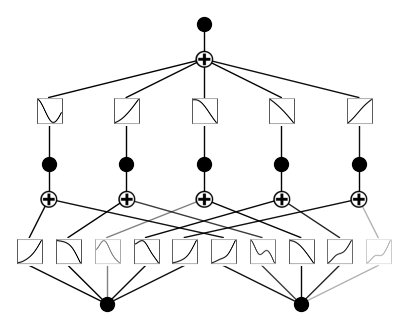

In [18]:
# Initial state
print("Initial model state:")
model(dataset['train_input'])
print("\nInitial model structure:")
model.plot()


| train_loss: 6.26e-03 | test_loss: 6.58e-03 | reg: 2.35e+01 | : 100%|█| 50/50 [00:24<00:00,  2.06it


saving model version 0.1


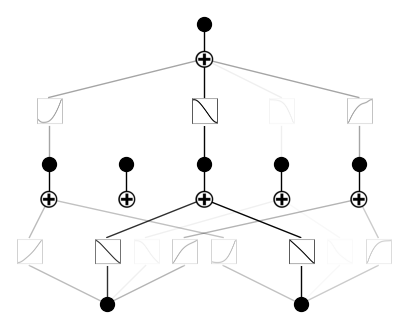

In [19]:
# Initial training
history = model.fit(dataset, opt="LBFGS", steps=50, lamb=0.0001)
model.plot()


saving model version 0.2


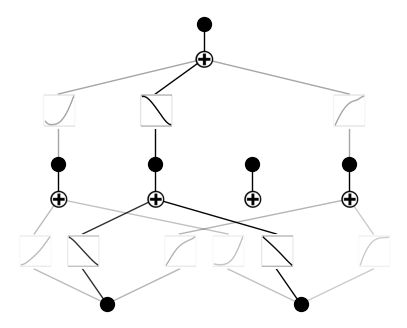

In [20]:
model = model.prune()
model.plot()


In [21]:
# Simple symbolic discovery
lib = ['x']  # Start with just linear terms
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.9794413960106777, c=1
fixing (0,0,1) with x, r2=0.998817735635901, c=1
fixing (0,0,2) with 0
fixing (0,0,3) with x, r2=0.9416651085184534, c=1
fixing (0,1,0) with x, r2=0.7895346438987672, c=1
fixing (0,1,1) with x, r2=0.9991803432856317, c=1
fixing (0,1,2) with 0
fixing (0,1,3) with x, r2=0.8101170008757547, c=1
fixing (1,0,0) with x, r2=0.5021368661879043, c=1
fixing (1,1,0) with x, r2=0.9901603589842207, c=1
fixing (1,2,0) with 0
fixing (1,3,0) with x, r2=0.8997121878399785, c=1
saving model version 0.3


In [22]:
# Get and display symbolic formula
formula = str(ex_round(model.symbolic_formula()[0][0], 4))
print("\nPredicted formula:", formula)


Predicted formula: 3.0985*x_1 + 4.8743*x_2 - 0.4896



Comparing with original function...


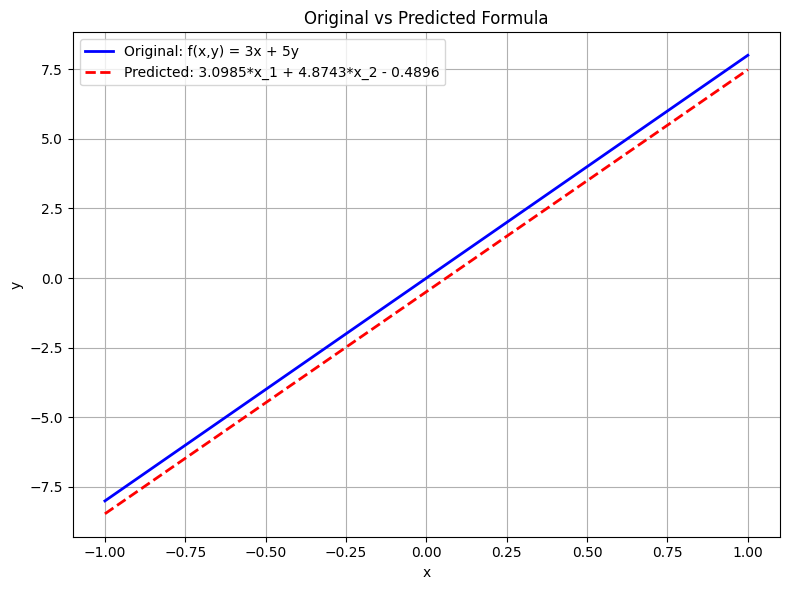


Formula Comparison:
Original: f(x,y) = 3x + 5y
Predicted: 3.0985*x_1 + 4.8743*x_2 - 0.4896

Metrics:
R² Score: 0.989192
MSE: 0.239979


In [23]:
# Compare with original function
print("\nComparing with original function...")
r2, mse = compare_functions(model, f)


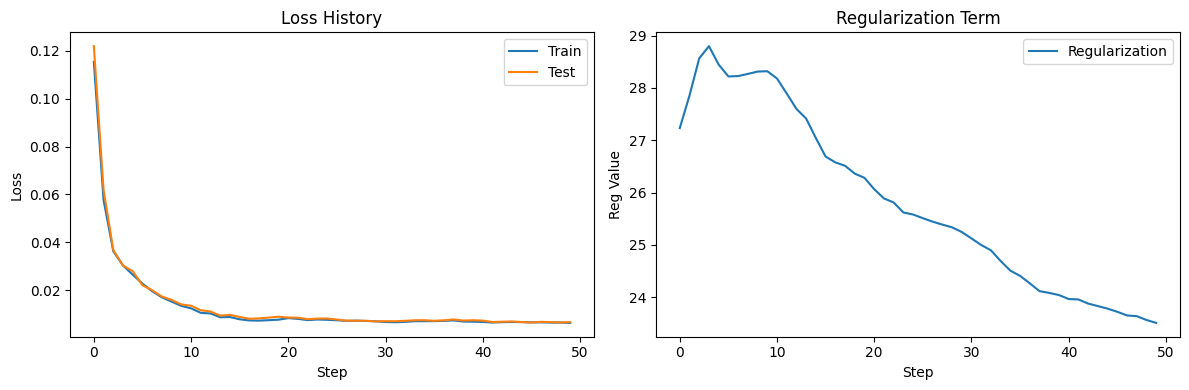

In [24]:
# Plot training history
plot_training_history(history)

In [25]:
# Create directory for saving plots if it doesn't exist
save_dir = '/home/user/WindowsShare/06. Programming/develop/JM_KAN/coef_tests'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Generate timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Extract coefficients from the original function
original = str(ex_round(f(torch.tensor([[1., 0.], [0., 1.]], dtype=torch.float64).to(model.device))[0], 4))
formula_name = original.replace('*', '').replace(' ', '').replace('+', '_').replace('.', '')

# Save formula comparison plot
plt.figure(figsize=(8, 6))
predicted = str(ex_round(model.symbolic_formula()[0][0], 4))

x = np.linspace(-1, 1, 50)
y = x
original_values = 3*x + 5*y
plt.plot(x, original_values, 'b-', label=f'Original: {original}', linewidth=2)

xy_points = torch.tensor(np.column_stack((x, y)), dtype=torch.float64).to(model.device)
with torch.no_grad():
    predicted_values = model(xy_points).cpu().numpy()
plt.plot(x, predicted_values, 'r--', label=f'Predicted: {predicted}', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Original vs Predicted Formula')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save comparison plot
comparison_filename = f'{save_dir}/formula_comparison_{formula_name}_{timestamp}.png'
plt.savefig(comparison_filename)
plt.close()

# Save loss history plot
plt.figure(figsize=(8, 6))
plt.plot(history['train_loss'], label='Train')
plt.plot(history['test_loss'], label='Test')
plt.title('Loss History')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save loss plot
loss_filename = f'{save_dir}/loss_history_{formula_name}_{timestamp}.png'
plt.savefig(loss_filename)
plt.close()

# Save regularization plot
plt.figure(figsize=(8, 6))
plt.plot(history['reg'], label='Regularization', color='green')
plt.title('Regularization Term')
plt.xlabel('Step')
plt.ylabel('Reg Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save regularization plot
reg_filename = f'{save_dir}/regularization_{formula_name}_{timestamp}.png'
plt.savefig(reg_filename)
plt.close()

print(f"Plots saved as:\n{comparison_filename}\n{loss_filename}\n{reg_filename}")

Plots saved as:
plots/formula_comparison_tensor([3],device='cuda:0')_20241203_172538.png
plots/loss_history_tensor([3],device='cuda:0')_20241203_172538.png
plots/regularization_tensor([3],device='cuda:0')_20241203_172538.png
